In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
##################
# LOADING AND PREPROCESSING DATA
##################

BASE_DIR = "skin_cancer_dataset/"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# image size and batch size
IMG_SIZE = (224, 224)     # this is the optimal size for EfficientNetB0
BATCH_SIZE = 32

# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,     # normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# rescaling only for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# load training data 
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"     # binary classification between diseases 
)

# load testing data
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# print class labels
print("Class Mapping:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


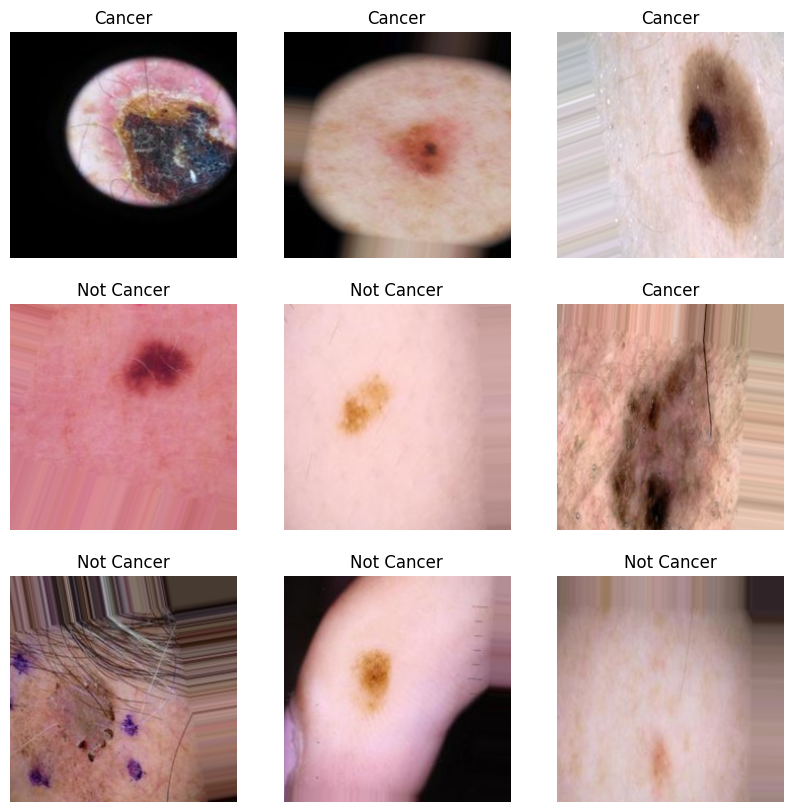

In [4]:
##################
# EXPLORATORY DATA ANALYSIS (EDA)
##################

# displaying same images from dataset
def plot_images(generator):
    images, labels = next(generator)     # getting a batch of images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Not Cancer")
        plt.axis("off")
    plt.show()

# plotting training images
plot_images(train_generator)

In [5]:
##################
# BUILDING THE CNN MODEL
##################

from tensorflow.keras import models, layers

model = models.Sequential([
    ## 1st convolution block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),

    ## 2nd convolution block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    ## 3rd convolution block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    ## flattening layer
    layers.Flatten(),

    ## fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),     # reducing overfitting
    layers.Dense(1, activation='sigmoid')     # output layer for binary classification
])

# compiling model
model.compile(optimizer='adam',     # optimizer for faster convergence
              loss='binary_crossentropy',     # binary classification loss
              metrics=['accuracy'])

# model summary
model.summary()

/Users/harshpatel/Documents/Projects/skin_cancer_detector/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
##################
# TRAIN AND EVALUATE MODEL
##################

"""
# early stopping to stop training when the model stops improving 
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,     # stop training after 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau to reduce the learning rate if the model stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,     # reduce LR if no improvement after 3 epochs
    min_lr=1e-7,
    verbose=1
)
"""

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

Epoch 1/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 189s 505ms/step - accuracy: 0.7142 - loss: 0.5607 - val_accuracy: 0.7737 - val_loss: 0.4727
Epoch 2/100
  1/371 ━━━━━━━━━━━━━━━━━━━━ 2:56 476ms/step - accuracy: 0.7188 - loss: 0.5043

/Users/harshpatel/Documents/Projects/skin_cancer_detector/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7188 - loss: 0.5043 - val_accuracy: 0.7883 - val_loss: 0.4711
Epoch 3/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 184s 495ms/step - accuracy: 0.8162 - loss: 0.4177 - val_accuracy: 0.7631 - val_loss: 0.4962
Epoch 4/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7812 - loss: 0.5532 - val_accuracy: 0.7515 - val_loss: 0.5217
Epoch 5/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 161s 433ms/step - accuracy: 0.8292 - loss: 0.3939 - val_accuracy: 0.8211 - val_loss: 0.3960
Epoch 6/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7812 - loss: 0.5892 - val_accuracy: 0.8266 - val_loss: 0.3853
Epoch 7/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 163s 439ms/step - accuracy: 0.8272 - loss: 0.3940 - val_accuracy: 0.8145 - val_loss: 0.3936
Epoch 8/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8438 - loss: 0.3203 - val_accuracy: 0.7999 - val_loss: 0.4089
Epoch 9/100
371/371 ━━━━━━━━━━━━━━━━━━━━ 158s 425ms/step - accuracy: 0.8334 - loss: 0.3755 - 

In [7]:
scores = model.evaluate(train_generator)

372/372 ━━━━━━━━━━━━━━━━━━━━ 81s 217ms/step - accuracy: 0.8910 - loss: 0.2511


In [8]:
test_score = model.evaluate(test_generator)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.9045 - loss: 0.2621


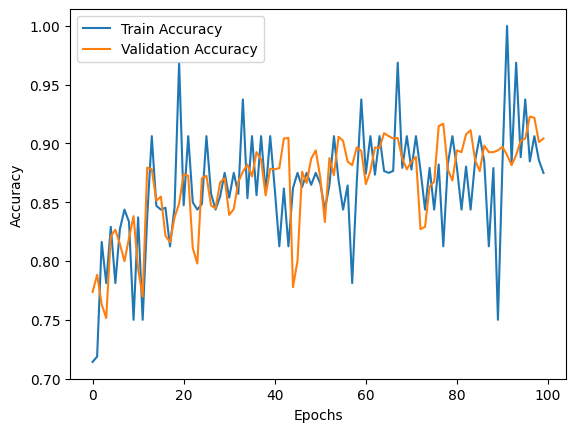

In [9]:
# saving the model
model.save("skin_cancer_cnn.h5")

# plotting training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1000
           1       0.50      0.48      0.49       984

    accuracy                           0.50      1984
   macro avg       0.50      0.50      0.50      1984
weighted avg       0.50      0.50      0.50      1984



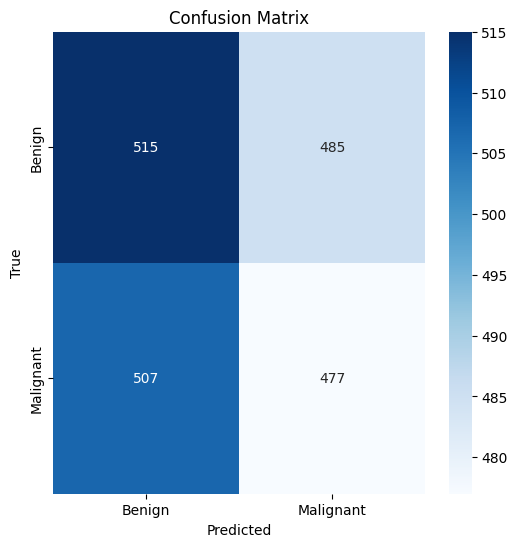

In [10]:
##################
# EVALUATING THE MODEL PERFORMACE
##################

# prediction on the test dataset
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# converting predictions into binary labels 0 or 1
test_pred_labels = (test_pred > 0.5).astype("int32")

# getting the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]     # matches length to predictions

print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

# confusion matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# plotting confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [11]:
##################
# PREDICTION SYSTEM
##################

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# loading the entire model
model = load_model('skin_cancer_cnn.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))     # loading image
    img_array = image.img_to_array(img) / 255.0     # normalizing
    img_array = np.expand_dims(img_array, axis=0)     # adding batch dimension

    # making the prediciton
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    
    # showing the result 
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


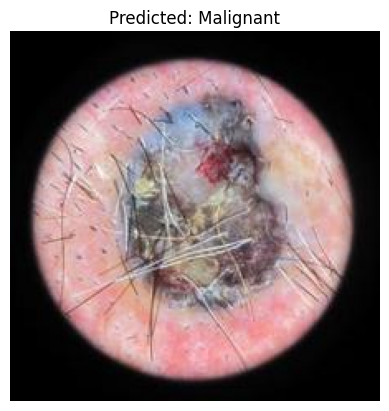

In [12]:
predict_skin_cancer("skin_cancer_dataset/test/Malignant/5616.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


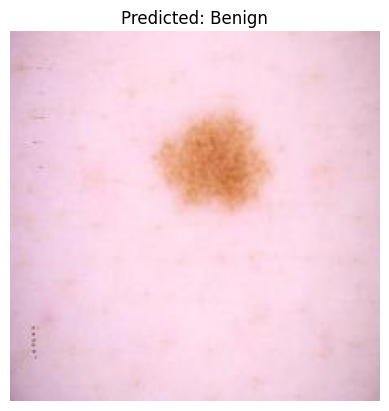

In [14]:
predict_skin_cancer("skin_cancer_dataset/train/Malignant/5602.jpg", model)

In [ ]:
"""
the above output is correct even though its coming from the malignant dataset because i put a benign image in that dataset 
to test if it can predict correctly
"""